In [ ]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import warnings
import sys
import subprocess
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import pipeline
import torch
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import torch


pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

model_name = "roberta-large-mnli"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
ds = load_dataset("wangrongsheng/ag_news")


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [31]:
def start_gemma2_session():
    """
    Start Gemma2 through Ollama and return the process instance.

    Returns:
        subprocess.Popen: Persistent Gemma2 process.
    """
    gemma2_process = subprocess.Popen(
        ["ollama", "run", "gemma2"],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    return gemma2_process


In [ ]:
def interact_with_gemma2(gemma2_process, prompt):
    """
    Send a prompt to Gemma2 and retrieve its response.

    Args:
        gemma2_process (subprocess.Popen): The running Gemma2 process.
        prompt (str): The prompt to send.

    Returns:
        str: The response from Gemma2.
    """
    # Write the prompt to Gemma2
    gemma2_process.stdin.write(prompt + "\n")
    gemma2_process.stdin.flush()

    # Read the response
    response = gemma2_process.stdout.readline().strip()
    return response


In [27]:
classifier = pipeline('zero-shot-classification', model=model_name, device=1)                              
sequence_to_classify = "This is a test"
candidate_labels = ['travel', 'cooking', 'dancing', 'technician', 'teacher']
classifier(sequence_to_classify, candidate_labels)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'sequence': 'This is a test',
 'labels': ['technician', 'travel', 'teacher', 'dancing', 'cooking'],
 'scores': [0.43758732080459595,
  0.1701793223619461,
  0.1603546291589737,
  0.13061030209064484,
  0.10126844793558121]}

In [ ]:
def perform_error_analysis(dataset, classifier, num_samples=100):
    """
    Perform comprehensive error analysis on the zero-shot classifier.
    
    Args:
        dataset: The AG News dataset
        classifier: The zero-shot classification pipeline
        num_samples: Number of samples to analyze (use smaller number for testing)
    """
    # AG News labels mapping
    # label_map = {
    #     0: "This document is about politics",
    #     1: "This document is about sports",
    #     2: "This document is about economics",
    #     3: "This document is about science and technology"
    # }
    
    label_map = {
        0: 'Global Affairs', 
        1: 'Sporting Events', 
        2: 'Financial News', 
        3: 'Scientific Discoveries' 
    }
    
    # Prepare candidate labels for zero-shot classification
    candidate_labels = list(label_map.values())
    
    # Store results
    results = []
    
    # Process test samples
    for i, item in tqdm(enumerate(dataset['test']), total=num_samples):
        if i >= num_samples:
            break
            
        text = item['text']
        true_label = label_map[item['label']]
        
        # Get model prediction
        prediction = classifier(text, candidate_labels)
        predicted_label = prediction['labels'][0]
        confidence = prediction['scores'][0]
        
        
        
        results.append({
            'text': text,
            'true_label': true_label,
            'predicted_label': predicted_label,
            'confidence': confidence,
            'correct': true_label == predicted_label
        })
    
    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    
    # 1. Overall Accuracy
    accuracy = (df_results['correct'].sum() / len(df_results)) * 100
    print(f"\nOverall Accuracy: {accuracy:.2f}%")
    
    # 2. Per-class Performance
    print("\nPer-class Performance:")
    print(classification_report(df_results['true_label'], df_results['predicted_label']))
    
    # 3. Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(df_results['true_label'], df_results['predicted_label'], labels=candidate_labels)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=candidate_labels, yticklabels=candidate_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 4. Confidence Analysis
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='true_label', y='confidence', hue='correct', data=df_results)
    plt.title('Confidence Distribution by Class and Correctness')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 5. Error Examples Analysis
    print("\nMost Confident Mistakes:")
    mistakes = df_results[~df_results['correct']].sort_values('confidence', ascending=False)
    print(mistakes[['text', 'true_label', 'predicted_label', 'confidence']].head())
    
    # 6. Length Analysis
    df_results['text_length'] = df_results['text'].str.len()
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='true_label', y='text_length', hue='correct', data=df_results)
    plt.title('Text Length Distribution by Class and Correctness')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return df_results

In [61]:
def analyze_error_patterns(df_results):
    """
    Analyze specific patterns in the errors.
    """
    # Common misclassification patterns
    error_patterns = defaultdict(int)
    for _, row in df_results[~df_results['correct']].iterrows():
        pattern = f"{row['true_label']} → {row['predicted_label']}"
        error_patterns[pattern] += 1
    
    print("\nCommon Error Patterns:")
    for pattern, count in sorted(error_patterns.items(), key=lambda x: x[1], reverse=True):
        print(f"{pattern}: {count}")
        
    # Confidence threshold analysis
    thresholds = np.arange(0.1, 1.0, 0.1)
    accuracies = []
    coverage = []
    
    for threshold in thresholds:
        filtered_preds = df_results[df_results['confidence'] >= threshold]
        if len(filtered_preds) > 0:
            acc = (filtered_preds['correct'].sum() / len(filtered_preds)) * 100
            cov = (len(filtered_preds) / len(df_results)) * 100
            accuracies.append(acc)
            coverage.append(cov)
    
    # Ensure arrays are the same length before plotting
    min_len = min(len(accuracies), len(coverage))
    thresholds = thresholds[:min_len]
    accuracies = accuracies[:min_len]
    coverage = coverage[:min_len]
    
    if min_len > 0:  # Only plot if we have data
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, accuracies, 'b-', label='Accuracy')
        plt.plot(thresholds, coverage, 'r-', label='Coverage')
        plt.xlabel('Confidence Threshold')
        plt.ylabel('Percentage')
        plt.title('Accuracy vs Coverage Trade-off')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Warning: Not enough data points to create accuracy-coverage plot")


STOP

In [ ]:
# Example usage
if __name__ == "__main__":
    # Initialize Gemma2 session
    gemma2 = start_gemma2_session()

    # Initial prompt
    initial_prompt = "You are an expert prompt generator for a zero shot text classification task. I am using roberta-large-mnli to do zero shot classification on the ag news dataset. I will first provide you with initial actual prompts then iteratively I will provide you with the current prompts that have been given to the model and the corresponding accuracy of the model per label on the task, I want you to provide better prompts for all the four labels so that the accuracy of the model improves. We will have many iterations of this process and I want you to iteratively give better prompts. Your output should be of the format 0: 'prompt0', 1: 'prompt1', 2: 'prompt2', 3: 'prompt3', where the values of the dictionary correpond to the prompts that you generate. Do not generate any text other than these prompts in dictionary format."
    current_prompt = initial_prompt

    # Iteratively refine the prompt using Gemma2
    iterations = 3
    for i in range(iterations):
        print(f"Iteration {i + 1}: Current Prompt -> {current_prompt}")
        refined_prompt = interact_with_gemma2(gemma2, current_prompt)
        print(f"Refined Prompt -> {refined_prompt}")
        current_prompt = refined_prompt

        # Use the refined prompt for classification
        print("\nUsing the final refined prompt for analysis...")
        candidate_labels = [f"{refined_prompt} ({label})" for label in ["politics", "sports", "economics", "science and technology"]]

        # Perform main error analysis with the refined prompt
        results_df = perform_error_analysis(ds, classifier, num_samples=500, prompt=refined_prompt)
        
        # Analyze error patterns
        analyze_error_patterns(results_df)

    # Terminate Gemma2 session
    gemma2.terminate()

  0%|          | 0/500 [00:00<?, ?it/s]


Overall Accuracy: 46.20%

Per-class Performance:
                                                                                                                                                                                precision    recall  f1-score   support

                          Does the article **explicitly mention** sports teams, scores, player names, or upcoming games, indicating a strong focus on Sports news and updates?       0.47      0.90      0.62       145
   Investigate if the article pertains to **traditional Business sectors**, such as Banking, Retail, or Manufacturing, including their financials, mergers, or market analysis       0.56      0.05      0.09       106
                       Is the articles core content centered on **non-US** governmental policies, international conflicts, or globally impactful events (World News Category)?       0.45      0.71      0.55       122
Reboot: Focus on **cutting-edge innovations**; Does the article discuss AI, Cybersecu

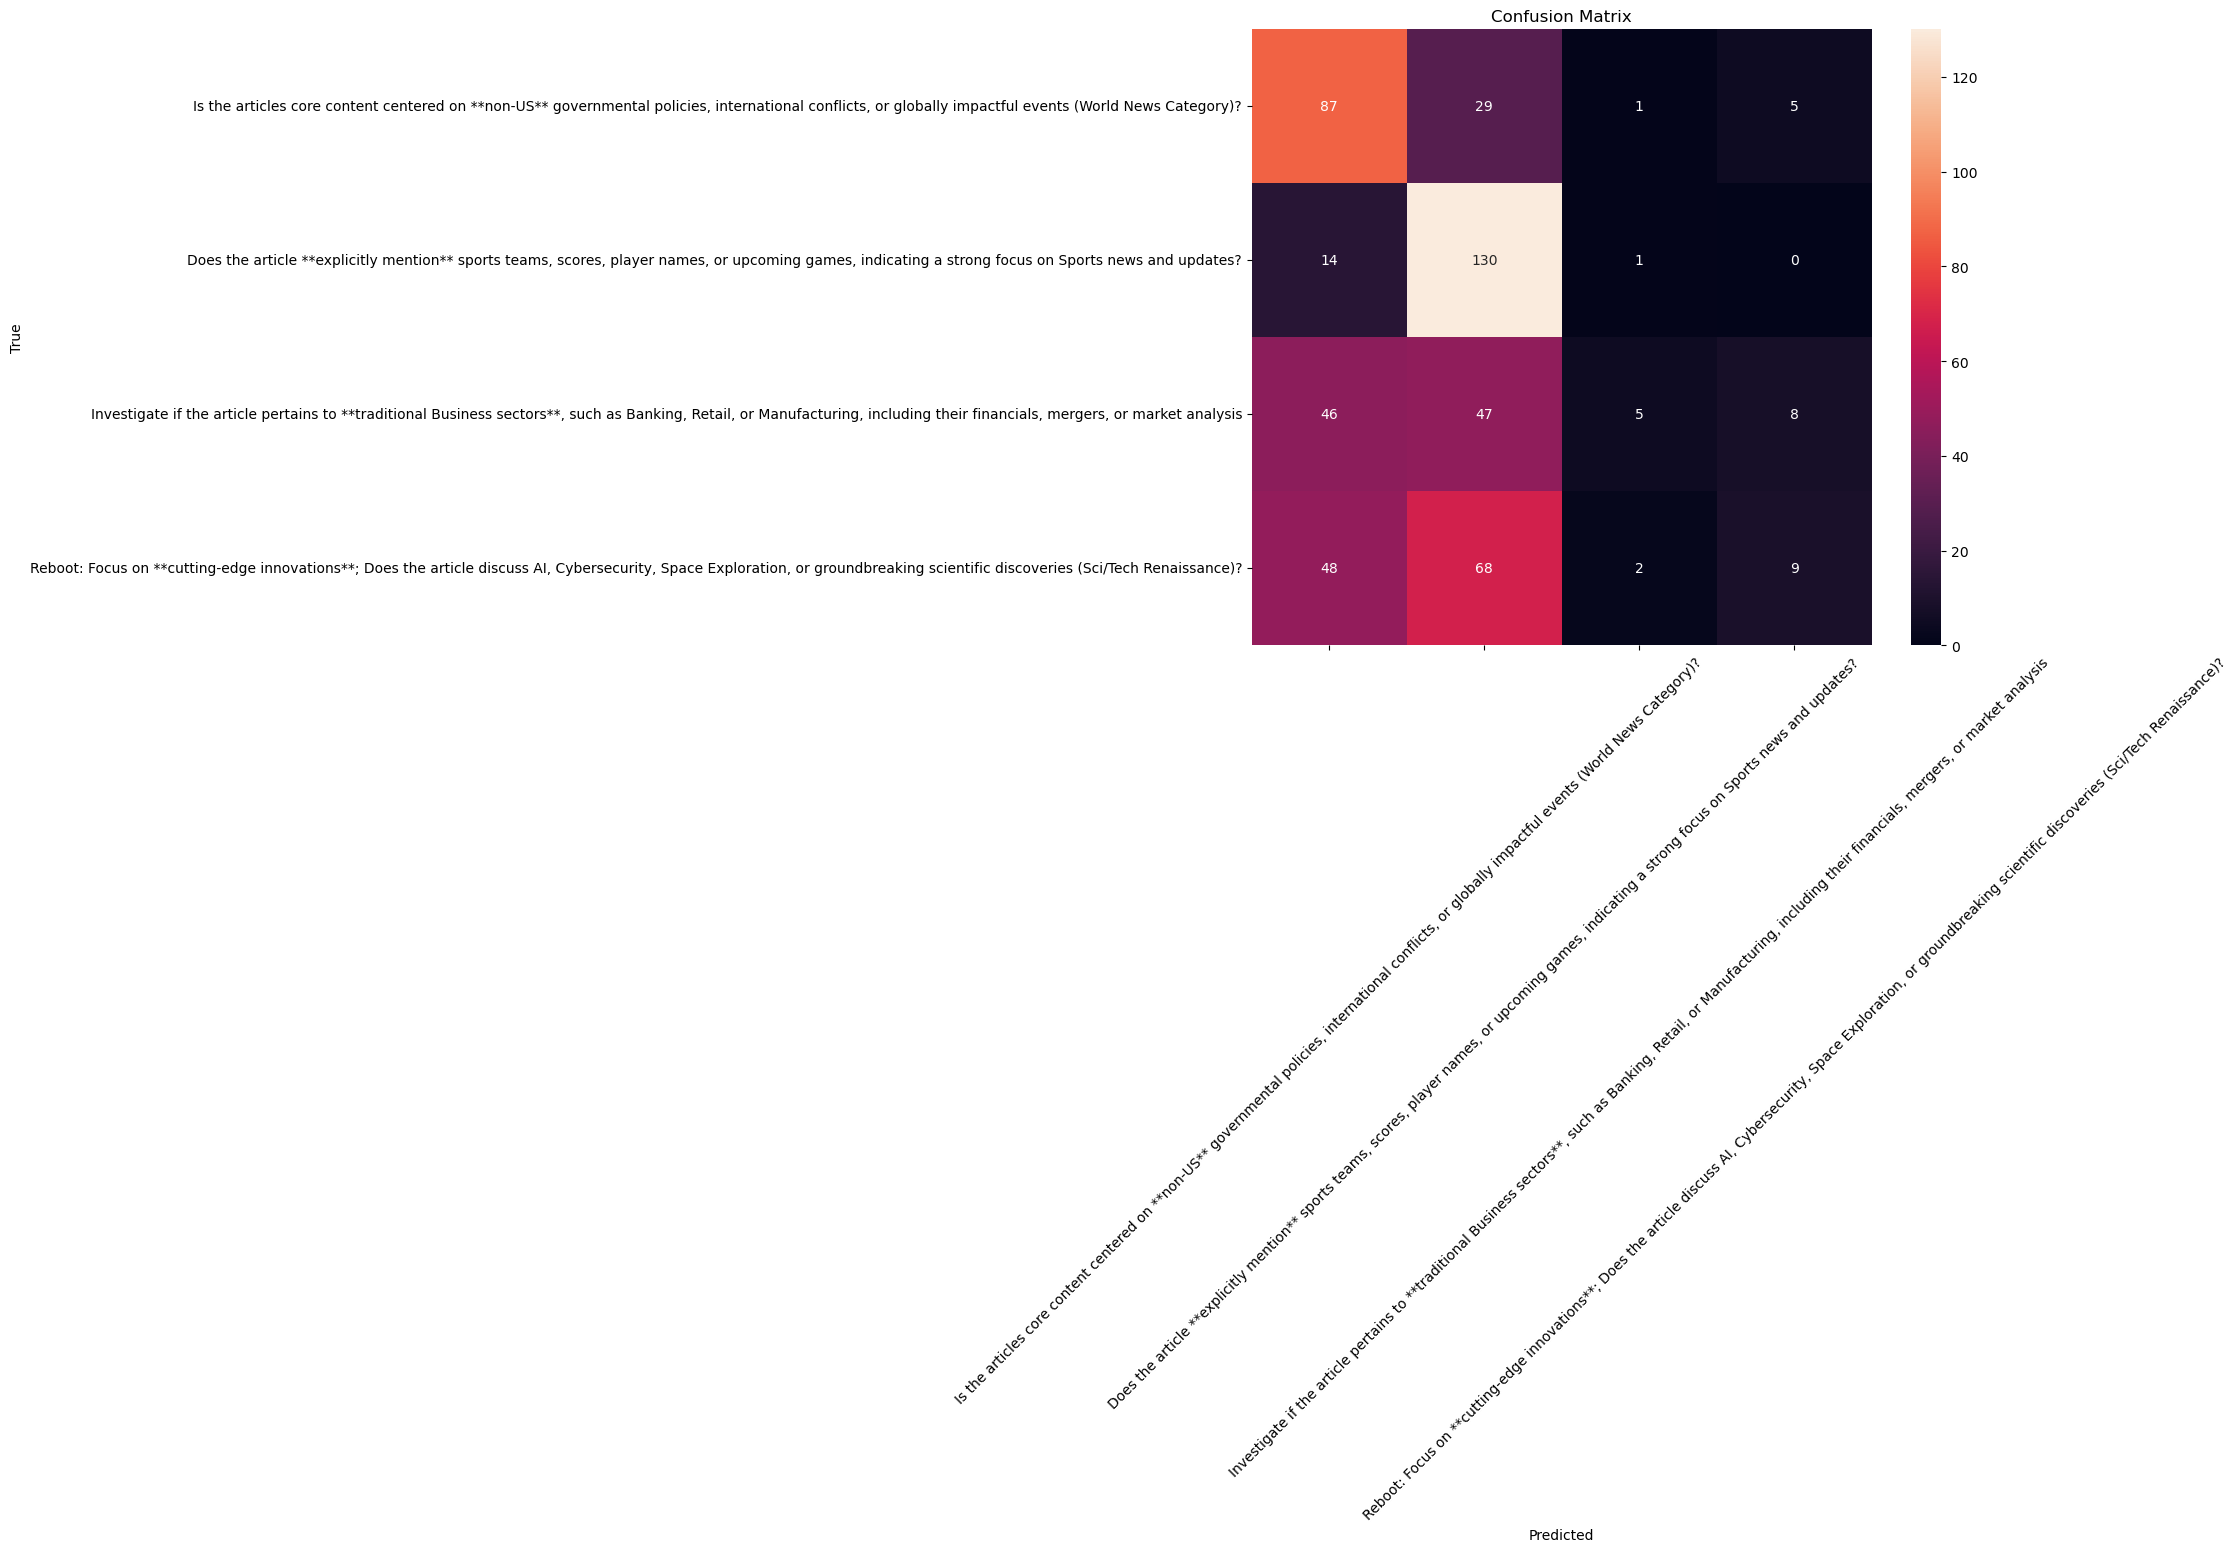

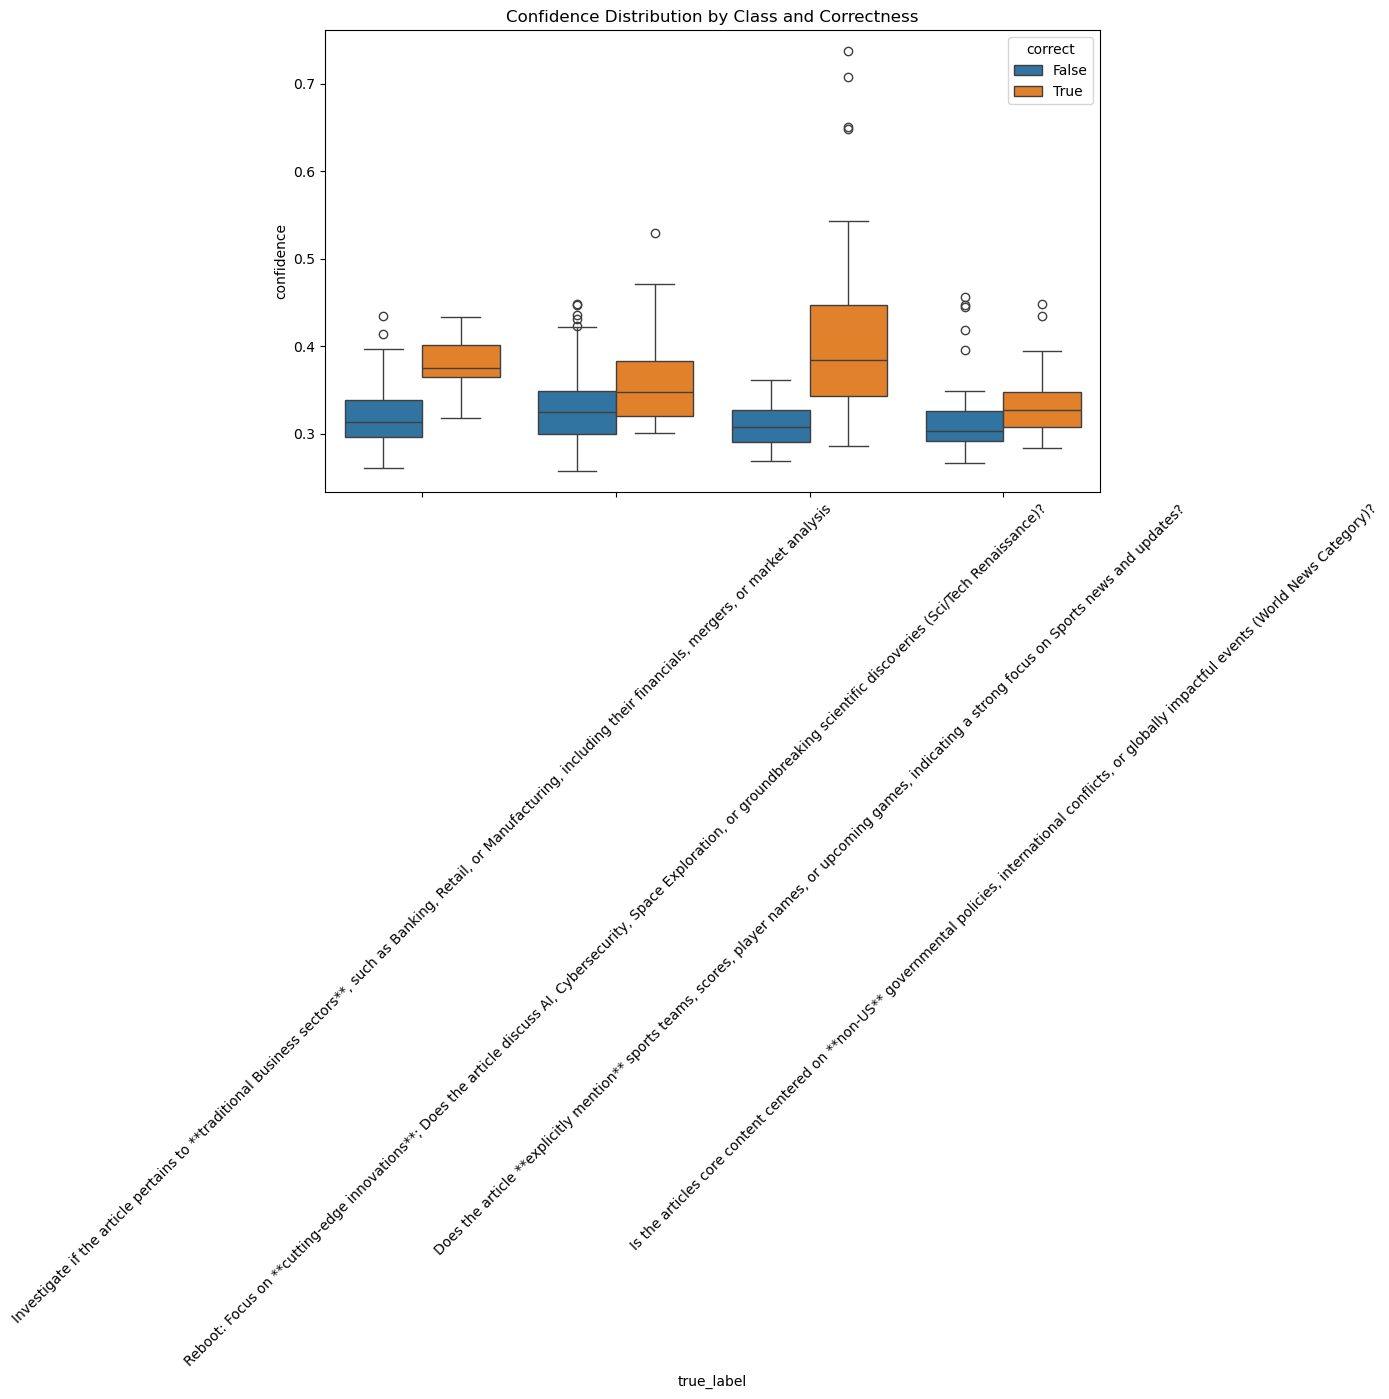


Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                                                                                                                                                                       text  \
369                                                                                        U.S. Softball Team Wins, Closes in on Gold ATHENS, Greece - Right now, the Americans aren't just a Dream Team - they're more like the Perfect Team. Lisa Fernandez pitched a three-hitter Sunday and Crystl Bustos drove in two runs as the Americans rolled to their eighth shutout in eight days, 5-0 over Australia, putting them into the gold medal game...   
292                                                                             

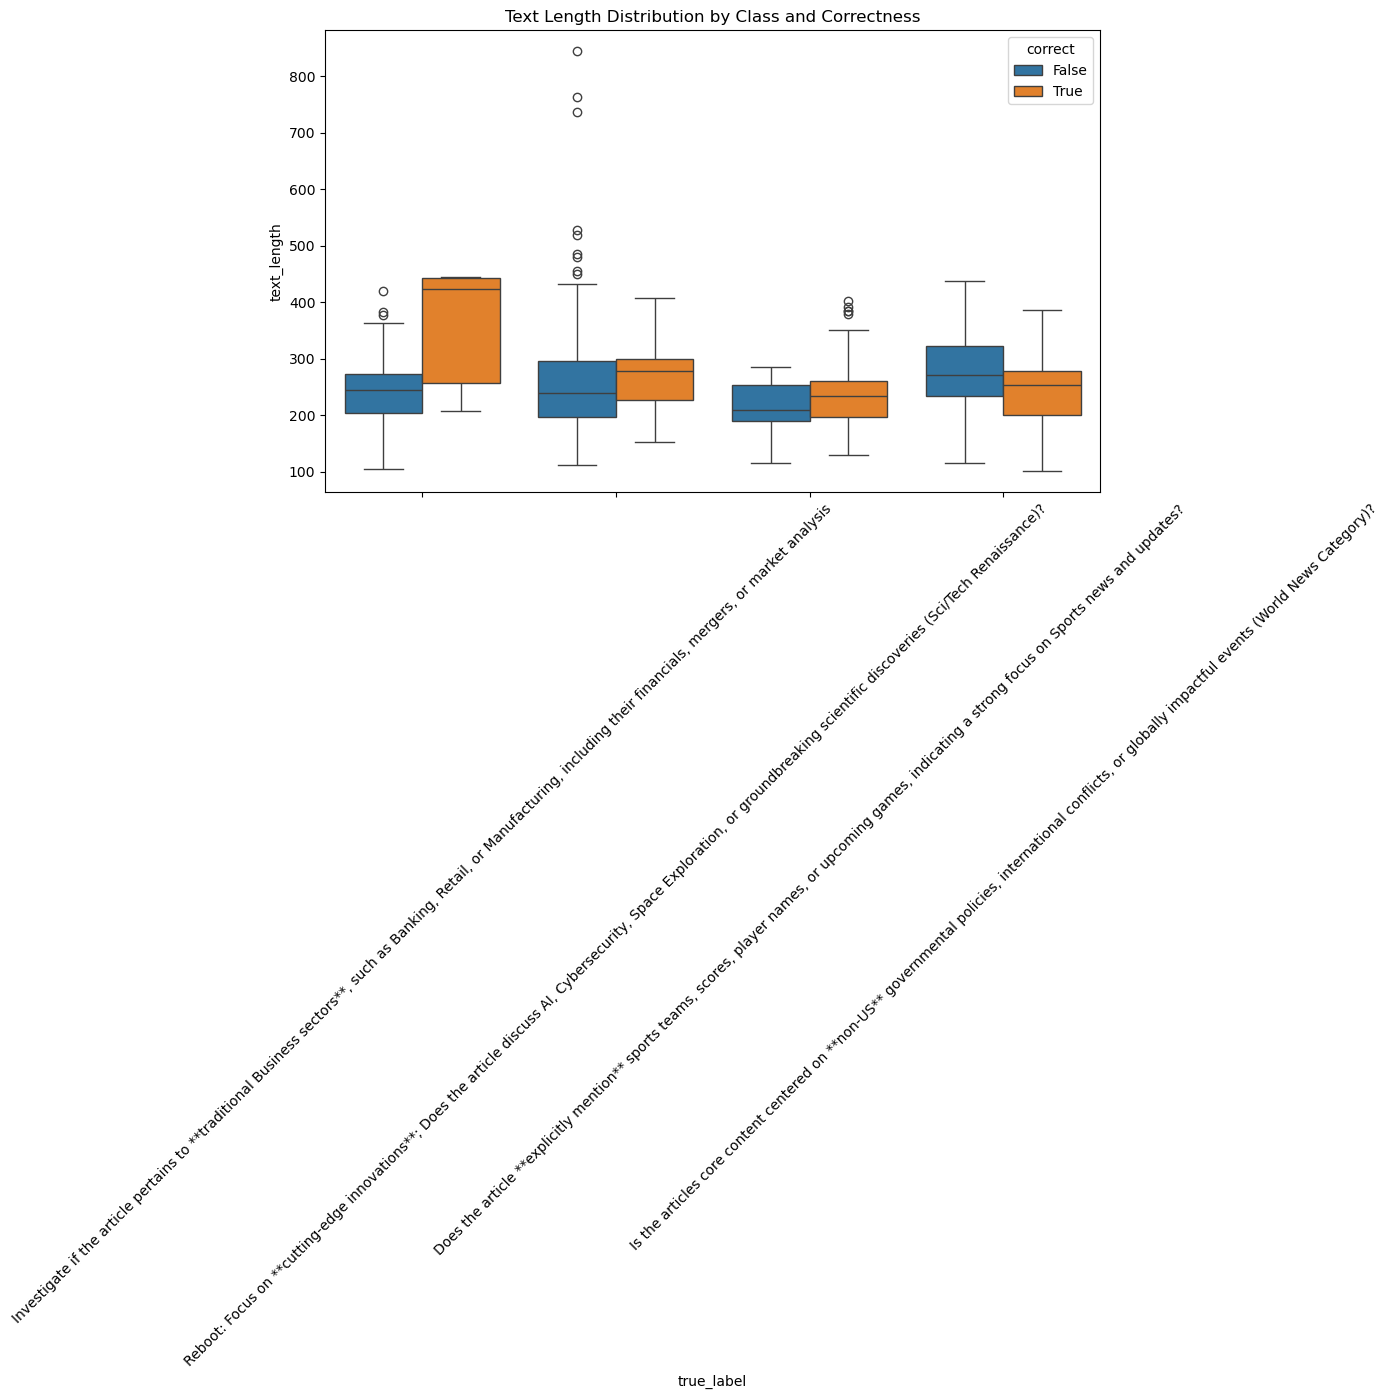


Common Error Patterns:
Reboot: Focus on **cutting-edge innovations**; Does the article discuss AI, Cybersecurity, Space Exploration, or groundbreaking scientific discoveries (Sci/Tech Renaissance)? → Does the article **explicitly mention** sports teams, scores, player names, or upcoming games, indicating a strong focus on Sports news and updates?: 68
Reboot: Focus on **cutting-edge innovations**; Does the article discuss AI, Cybersecurity, Space Exploration, or groundbreaking scientific discoveries (Sci/Tech Renaissance)? → Is the articles core content centered on **non-US** governmental policies, international conflicts, or globally impactful events (World News Category)?: 48
Investigate if the article pertains to **traditional Business sectors**, such as Banking, Retail, or Manufacturing, including their financials, mergers, or market analysis → Does the article **explicitly mention** sports teams, scores, player names, or upcoming games, indicating a strong focus on Sports news and

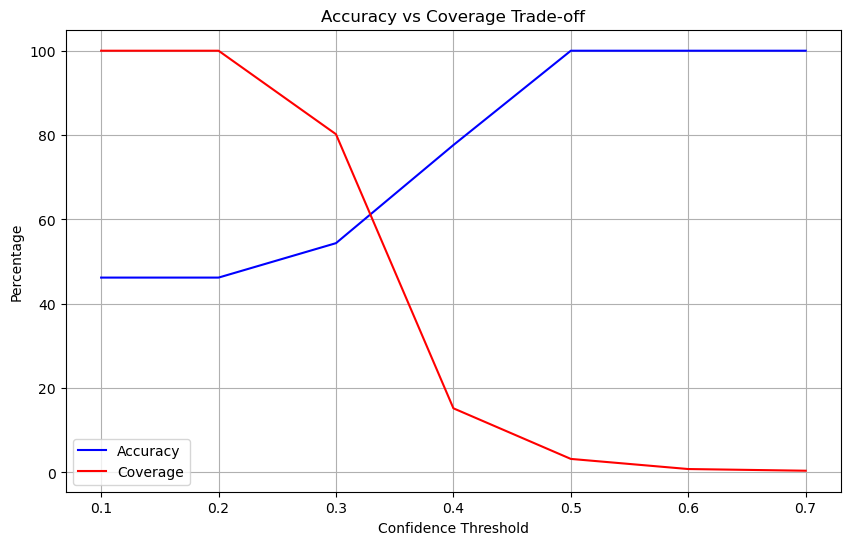

In [62]:
# Example usage
if __name__ == "__main__":
    # Perform main error analysis
    results_df = perform_error_analysis(ds, classifier, num_samples=500)
    
    # Analyze error patterns
    analyze_error_patterns(results_df)